In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement.io import npy
from kid_readout.measurement import basic, plot_basic
from kid_readout.analysis.timeseries import filters
from kid_readout.analysis.resonator import lmfit_resonator
import lmfit

In [2]:
save_directory = '/home/flanigan/temp/'
save_Sxx_Syy_vs_frequency_all_attenuations_3410_MHz = False

In [3]:
thesis_directory = '/home/flanigan/thesis/'
save_mkidarray02_chosen_one_noise_spectra = False
save_mkidarray02_chosen_one_x_fold_fit = False
save_mkidarray02_chosen_one_mmw_decimated_and_folded = False

In [1]:
# I saved the modulated time-ordered data for further analysis
data_directory = '/home/flanigan/data/'
save_chosen_one_data = False

In [4]:
npd = npy.NumpyDirectory('/data/readout/2017-12-15_093924_mmw.npd/')

In [5]:
npd.node_names()

['SingleSweep0',
 'SingleSweepStreamList1',
 'ADCSnap2',
 'SingleSweepStreamList3',
 'ADCSnap4',
 'SingleSweepStreamList5',
 'ADCSnap6']

In [6]:
initial = npd.SingleSweep0
all_sssl = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweepStreamList')]
all_snap = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

In [7]:
initial.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)
for sssl in all_sssl:
    sssl.single_sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)

In [8]:
def sss_from_sssl(sssl):
    stream_off, stream_mod, stream_on = sssl.stream_list
    sss_off = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=stream_off)
    sss_mod = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=stream_mod)
    sss_on = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=stream_on)
    return sss_off, sss_mod, sss_on

In [9]:
all_sss = [sss_from_sssl(sssl) for sssl in all_sssl]

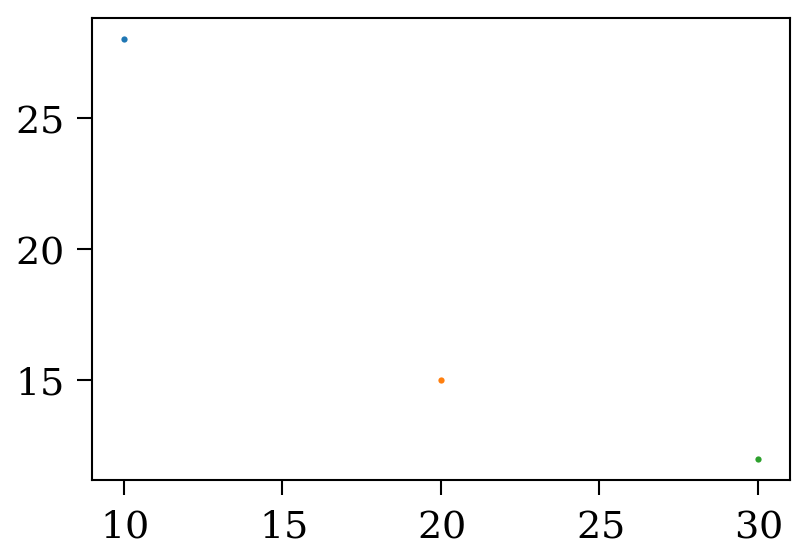

In [10]:
fig, ax = plt.subplots()
for sssl, snap in zip(all_sssl, all_snap):
    ax.plot(sssl.stream_list[2].roach_state.dac_attenuation, snap.x.ptp(), '.')

In [11]:
def plot_sssl(sss_off, sss_mod, sss_on):
    fig, (ax_off, ax_mod, ax_on) = plt.subplots(1, 3, figsize=(6, 2),
                                                gridspec_kw={'hspace': 0.4, 'wspace': 0.5})
    plot_basic.sss_complex_plane(axis=ax_off, sss=sss_off)
    ax_off.set_title("off, {:.1f} dB".format(sss_off.stream.roach_state.dac_attenuation), fontsize='xx-small')
    plot_basic.sss_complex_plane(axis=ax_mod, sss=sss_mod)
    ax_mod.set_title("mod, {:.1f} dB".format(sss_mod.stream.roach_state.dac_attenuation), fontsize='xx-small') 
    plot_basic.sss_complex_plane(axis=ax_on, sss=sss_on)
    ax_on.set_title("on, {:.1f} dB".format(sss_off.stream.roach_state.dac_attenuation), fontsize='xx-small')
    for ax in (ax_off, ax_mod, ax_on):
            ax.tick_params(labelsize='xx-small')
    return fig, (ax_off, ax_mod, ax_on)


def plot_Sxx(ax, sss_off, sss_mod, sss_on):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')
    ax.plot(sss_off.S_frequency, sss_off.S_xx, label='off: $S_{xx}$')
    ax.plot(sss_mod.S_frequency, sss_mod.S_xx, label='mod: $S_{xx}$')
    ax.plot(sss_on.S_frequency, sss_on.S_xx, label='on: $S_{xx}$')
    ax.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))

    
def plot_Sxy(ax, sss_off, sss_mod, sss_on):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')
    ax.plot(sss_off.S_frequency, np.real(sss_off.S_xy), label='off: Re $S_{xy}$')
    ax.plot(sss_off.S_frequency, np.imag(sss_off.S_xy), label='off: Im $S_{xy}$')
    ax.plot(sss_mod.S_frequency, np.real(sss_mod.S_xy), label='mod: Re $S_{xy}$')
    ax.plot(sss_mod.S_frequency, np.imag(sss_mod.S_xy), label='mod: Im $S_{xy}$')
    ax.plot(sss_on.S_frequency, np.real(sss_on.S_xy), label='on: Re $S_{xy}$')
    ax.plot(sss_on.S_frequency, np.imag(sss_on.S_xy), label='on: Im $S_{xy}$')
    ax.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))
    
    
def plot_Sxx_attenuation(ax, *some_sss):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')    
    for sss in some_sss:
        ax.plot(sss.S_frequency, sss.S_xx, label='{:.1f} dB'.format(sss.stream.roach_state.dac_attenuation))
    ax.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))

    
def plot_Sxy_attenuation(ax, *some_sss):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')    
    for sss in some_sss:
        ax.plot(sss.S_frequency, np.abs(sss.S_xy), label='{:.1f} dB'.format(sss.stream.roach_state.dac_attenuation))
    ax.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))

    
def plot_Sxx_Syy_attenuation(ax, *some_sss):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('spectral density / Hz$^{-1}$')    
    for sss in some_sss:
        ax.plot(sss.S_frequency, sss.S_xx,
                linestyle='-', label='$S_{xx}$: ' + '{:.1f} dB'.format(sss.stream.roach_state.dac_attenuation))
        ax.plot(sss.S_frequency, sss.S_yy,
                linestyle='--', label='$S_{yy}$: ' + '{:.1f} dB'.format(sss.stream.roach_state.dac_attenuation))
    ax.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))
    

def decimate(sss, downsample, num_taps=256):
    f_nyquist = sss.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=num_taps, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=num_taps, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]


def plot_decimated(ax, sss_off, sss_mod, sss_on, downsample=64):
    ax.set_xlabel('time / s')
    ax.set_ylabel('$10^6 \; x$')
    t_mod, x_mod, q_mod = decimate(sss_mod, downsample=downsample)
    t_off, x_off, q_off = decimate(sss_off, downsample=downsample)
    t_on, x_on, q_on = decimate(sss_on, downsample=downsample)
    ax.plot(t_mod, 1e6 * x_mod, label='mod')
    ax.plot(t_off, 1e6 * x_off, label='off')
    ax.plot(t_on, 1e6 * x_on, label='on')
    ax.legend(fontsize='xx-small', ncol=3)    

# Initial sweep

In [12]:
print("Initial resonance is {:.1f} MHz".format(1e-6 * initial.resonator.f_0))
print("Initial internal loss is {:.3g} = 1 / {:.3g}".format(initial.resonator.loss_i, 1 / initial.resonator.loss_i))
print("Initial coupling loss is {:.3g} = 1 / {:.3g}".format(initial.resonator.loss_c, 1 / initial.resonator.loss_c))

Initial resonance is 3409.7 MHz
Initial internal loss is 9.72e-05 = 1 / 1.03e+04
Initial coupling loss is 1.91e-05 = 1 / 5.22e+04


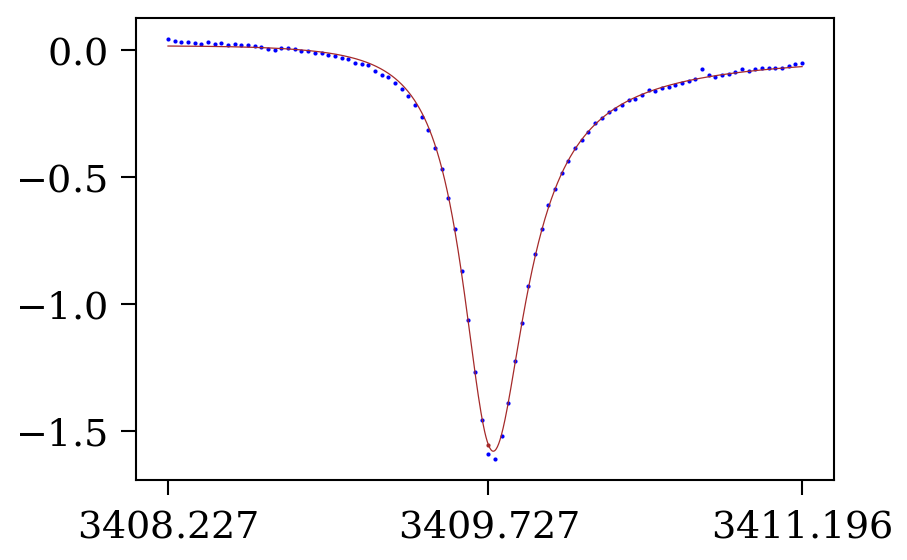

In [13]:
fig, ax = plt.subplots()
plot_basic.resonator_amplitude(axis=ax, resonator=initial.resonator);

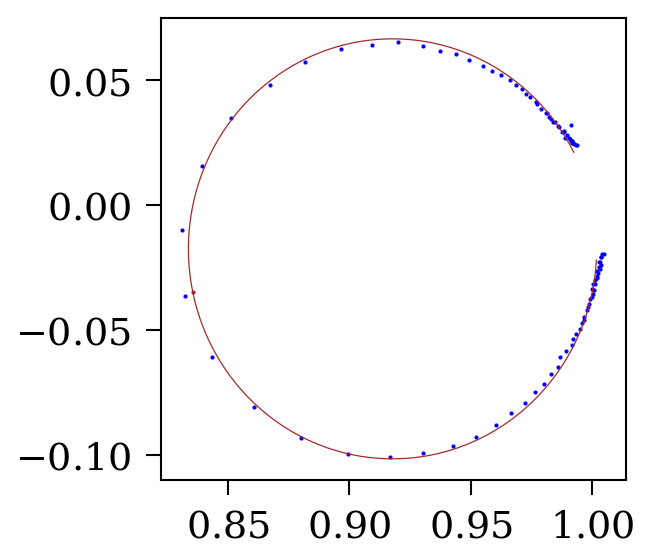

In [14]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.resonator_complex_plane(axis=ax, resonator=initial.resonator);

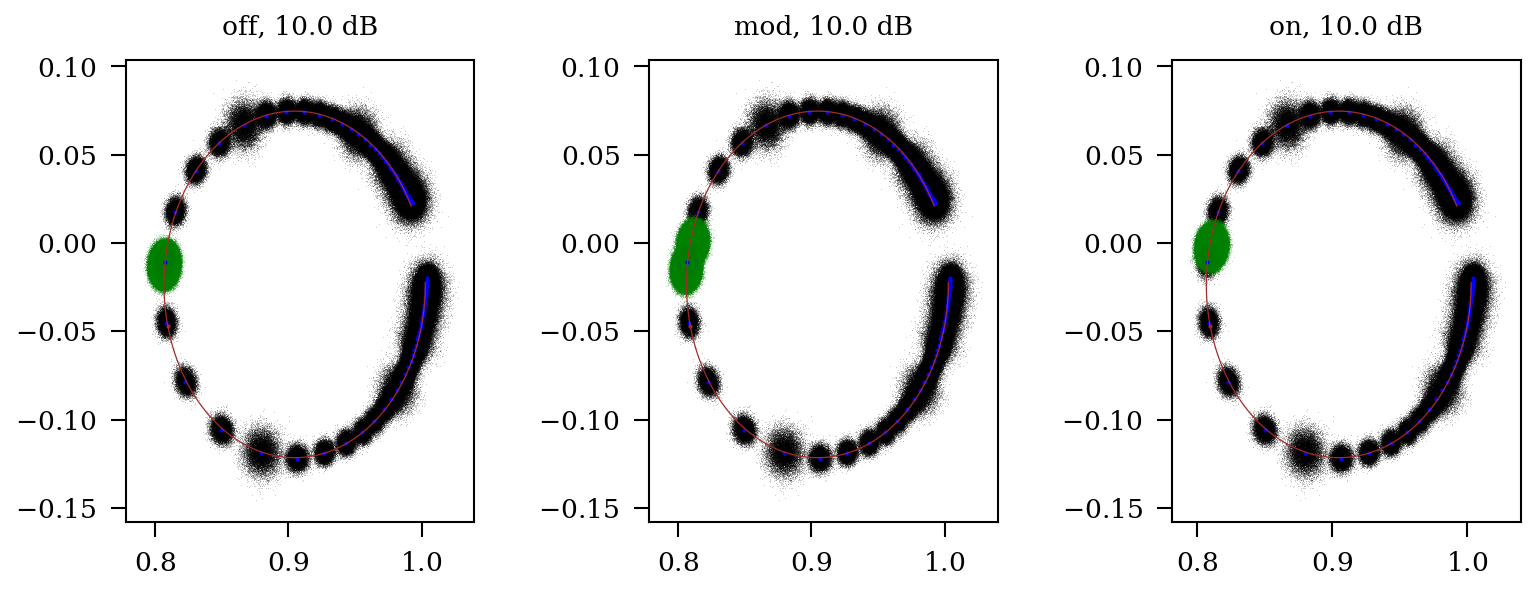

In [15]:
fig, axes = plot_sssl(*all_sss[0])

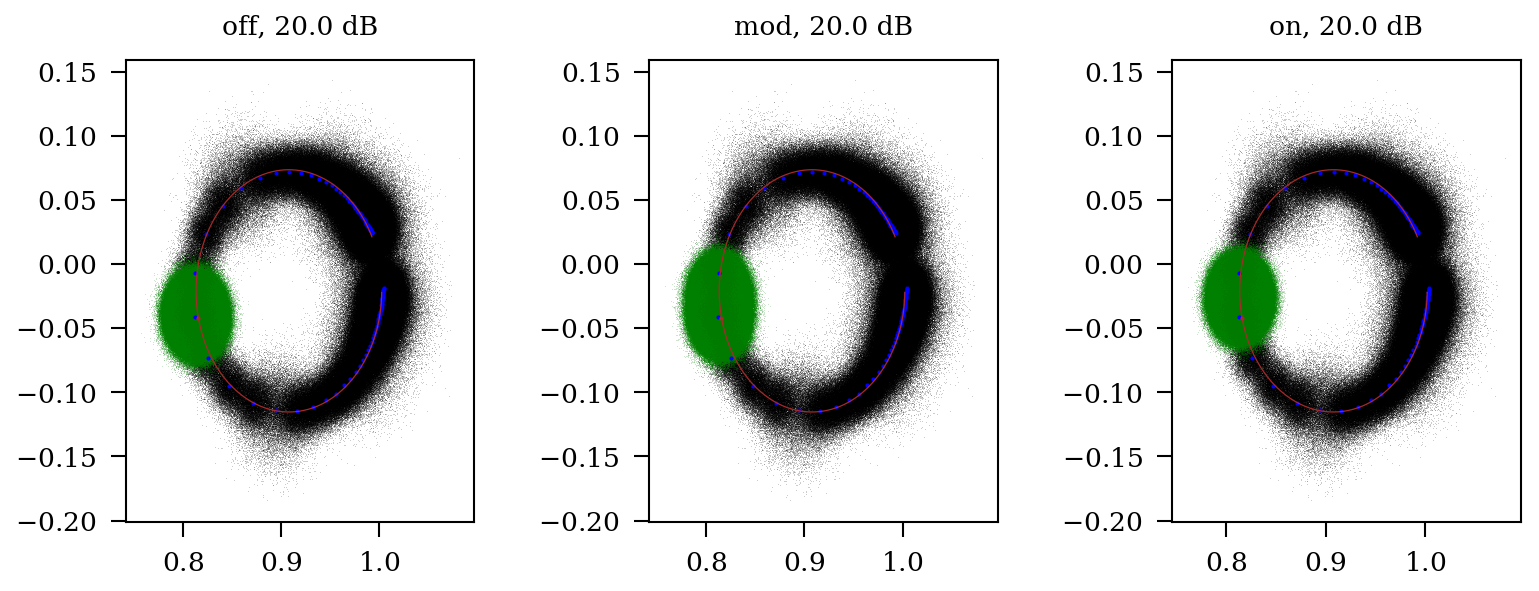

In [16]:
fig, axes = plot_sssl(*all_sss[1])

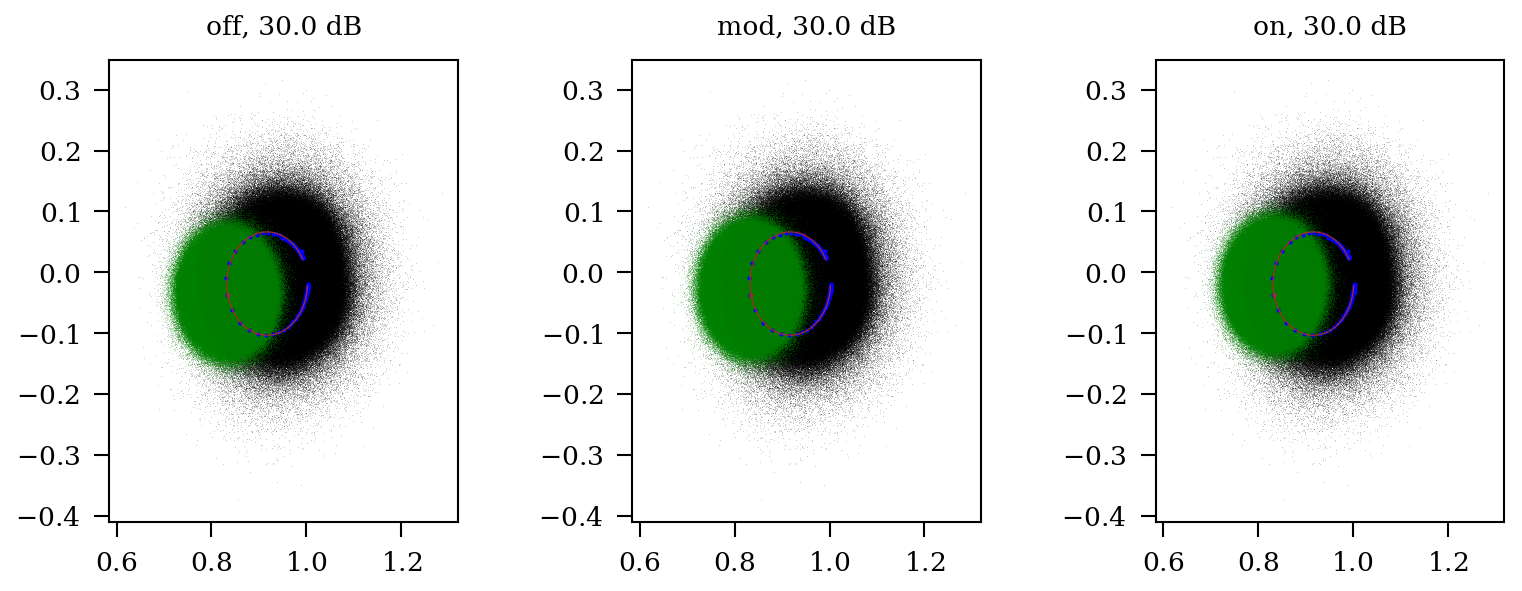

In [17]:
fig, axes = plot_sssl(*all_sss[2])

# Time -ordered data

/home/flanigan/readout/kid_readout/kid_readout/analysis/timeseries/fftfilt.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i:k] = y[i:k] + yt[:k-i]            # and add


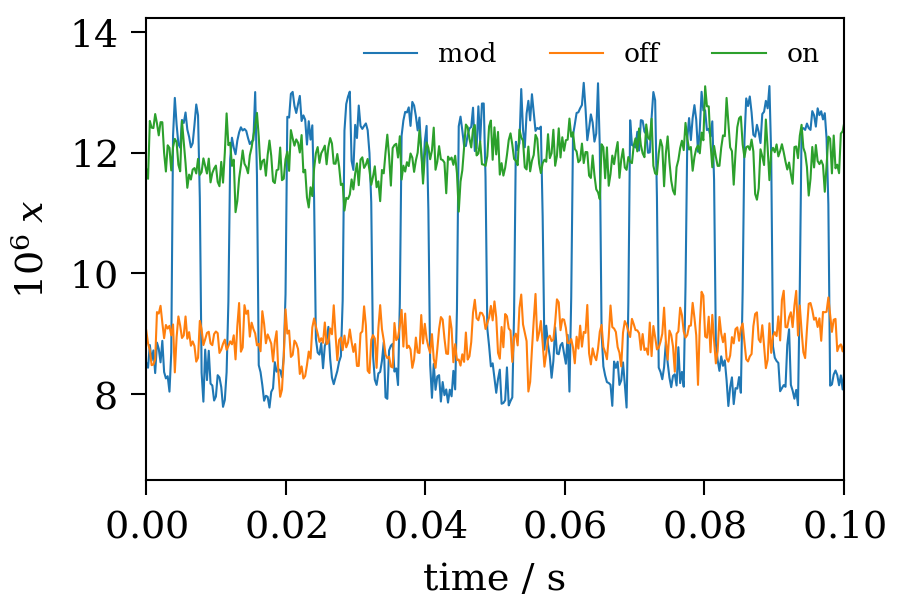

In [18]:
fig, ax = plt.subplots()
plot_decimated(ax, *all_sss[0], downsample=64)
ax.set_xlim(0, 0.1);

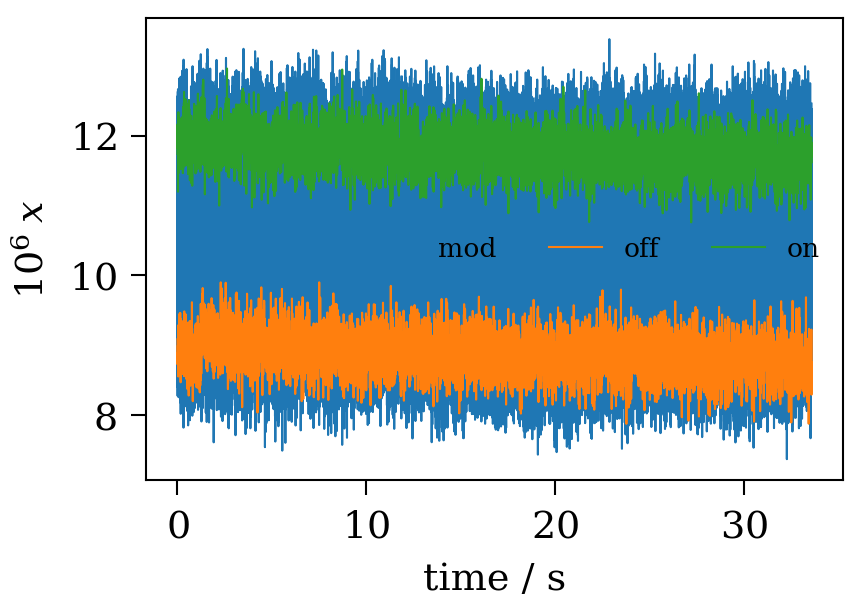

In [19]:
fig, ax = plt.subplots()
plot_decimated(ax, *all_sss[0], downsample=2**10)

# Noise spectra

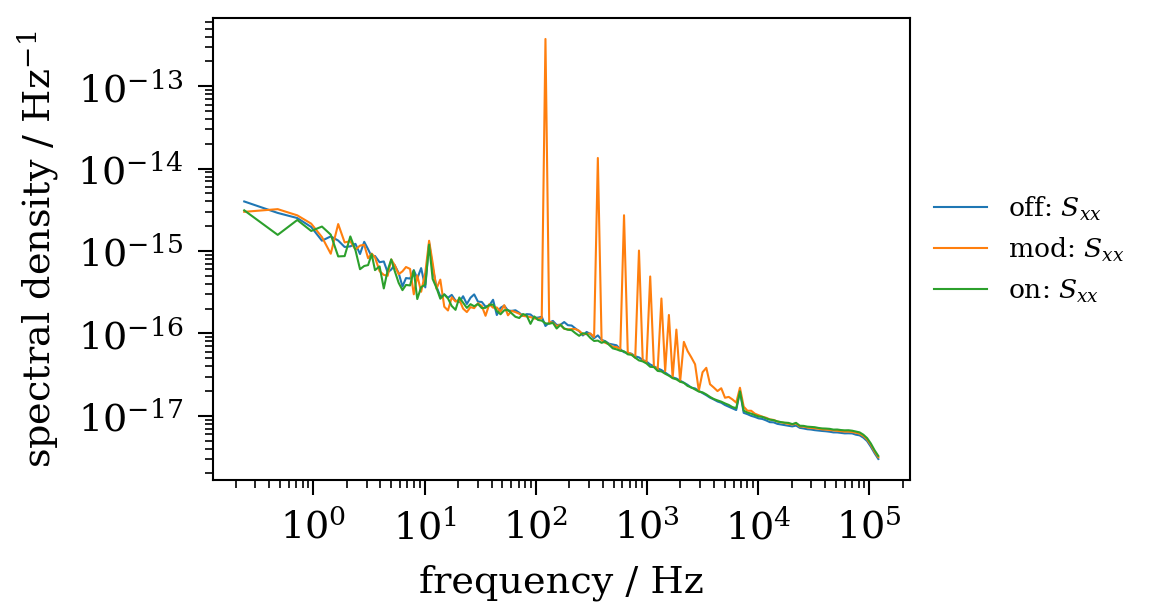

In [20]:
fig, ax = plt.subplots()
plot_Sxx(ax, *all_sss[0])

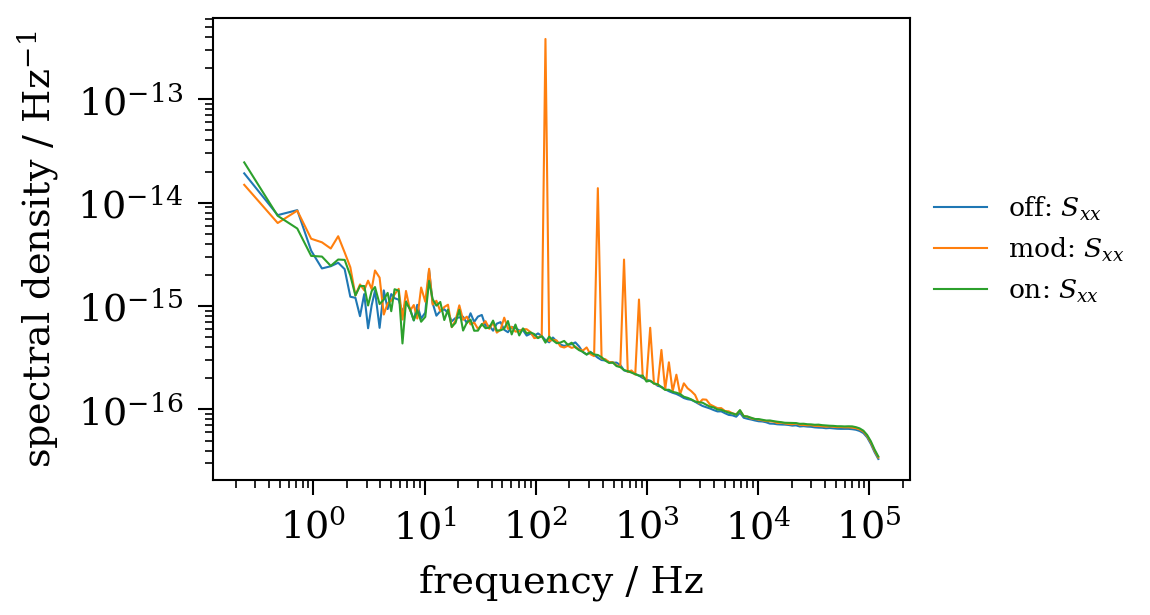

In [21]:
fig, ax = plt.subplots()
plot_Sxx(ax, *all_sss[1])

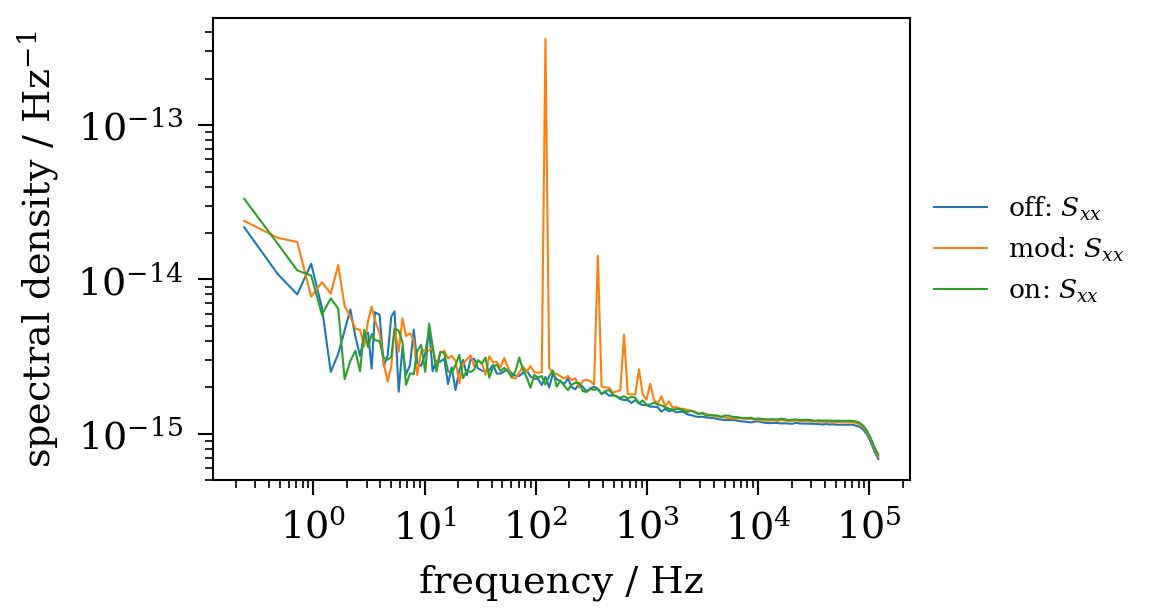

In [22]:
fig, ax = plt.subplots()
plot_Sxx(ax, *all_sss[2])

# Cross-spectrum

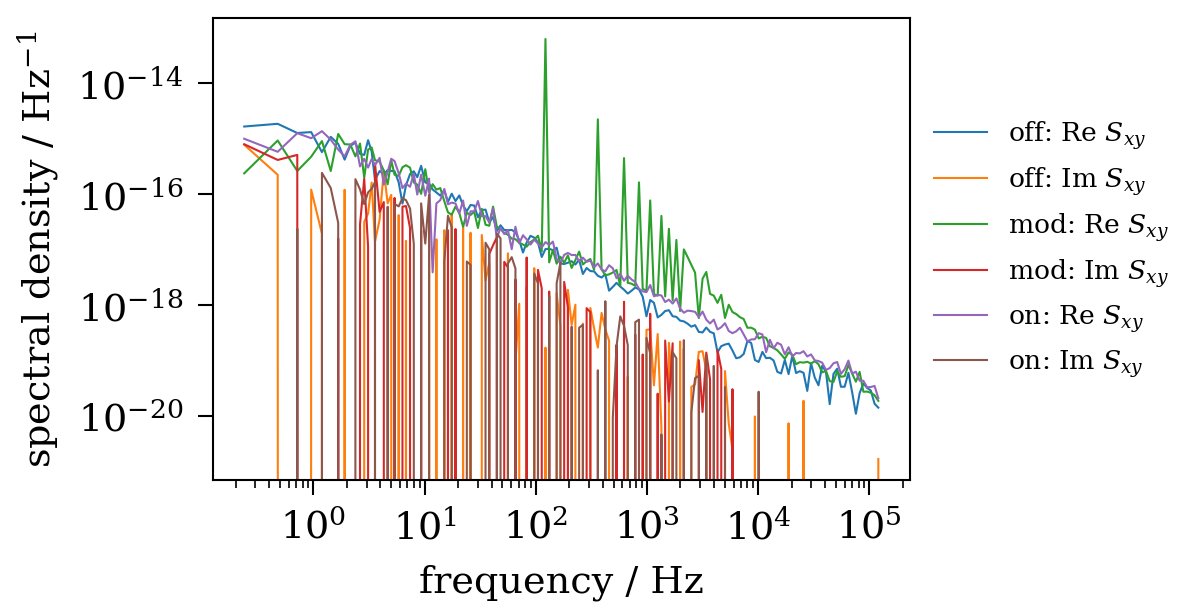

In [23]:
fig, ax = plt.subplots()
plot_Sxy(ax, *all_sss[0])
#ax.set_yscale('linear')
#ax.axhline(0, color='gray')
#ax.set_ylim(-1e-17, 1e-17);

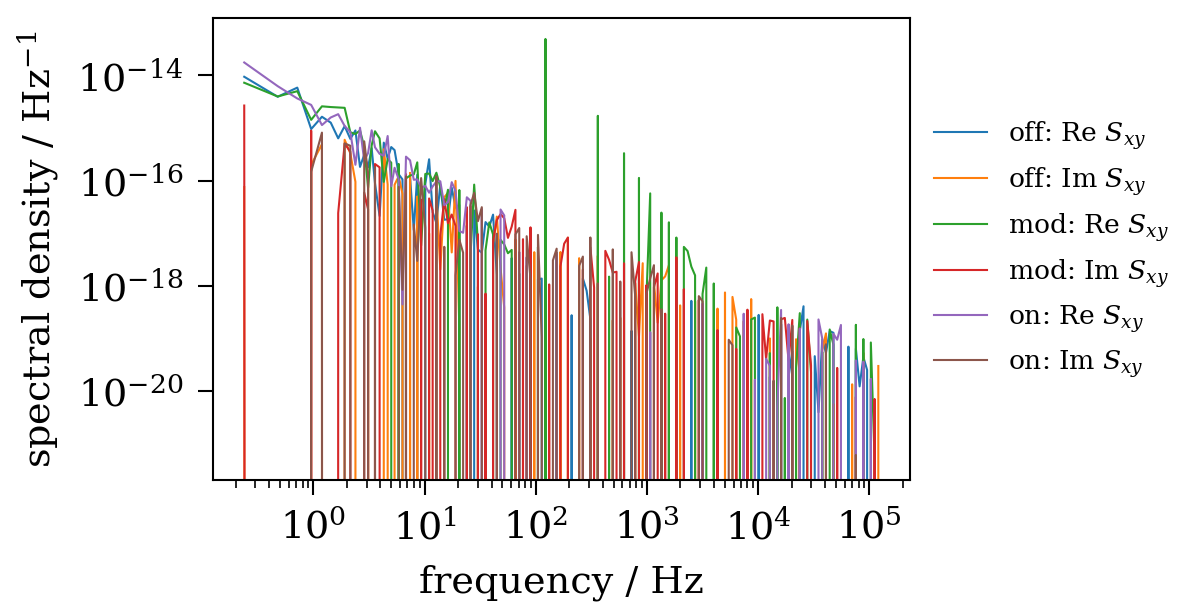

In [24]:
fig, ax = plt.subplots()
plot_Sxy(ax, *all_sss[1])
#ax.set_yscale('linear')
#ax.axhline(0, color='gray')
#ax.set_ylim(-1e-16, 1e-16);

In [25]:
sss_off = [sss_tuple[0] for sss_tuple in all_sss]
sss_mod = [sss_tuple[1] for sss_tuple in all_sss]
sss_on = [sss_tuple[2] for sss_tuple in all_sss]

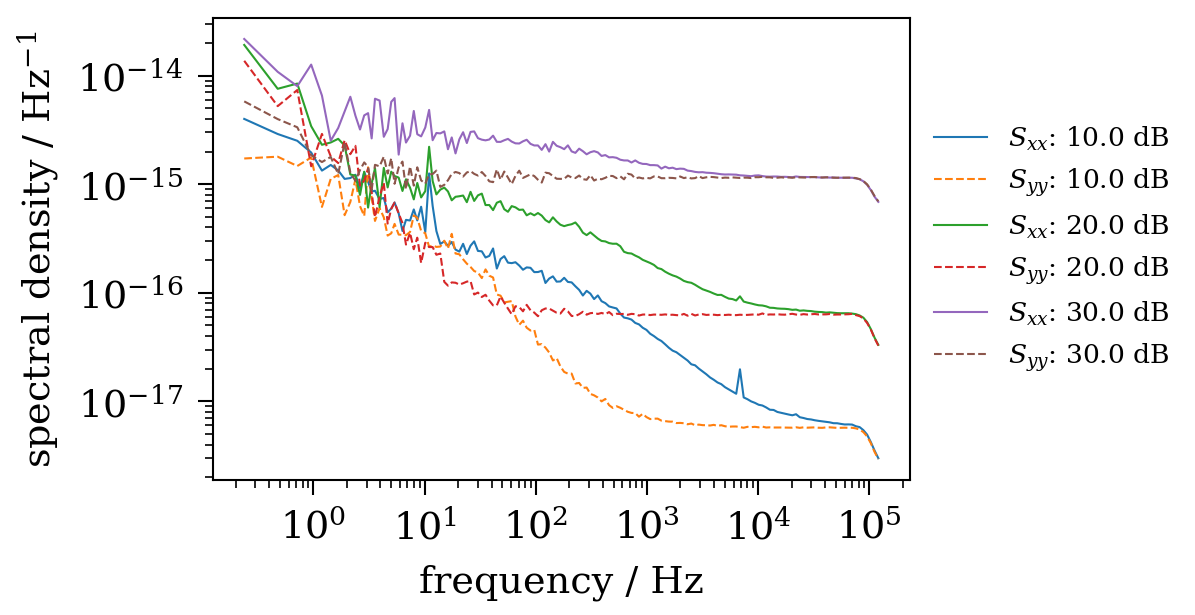

In [26]:
fig, ax = plt.subplots()
plot_Sxx_Syy_attenuation(ax, *sss_off)

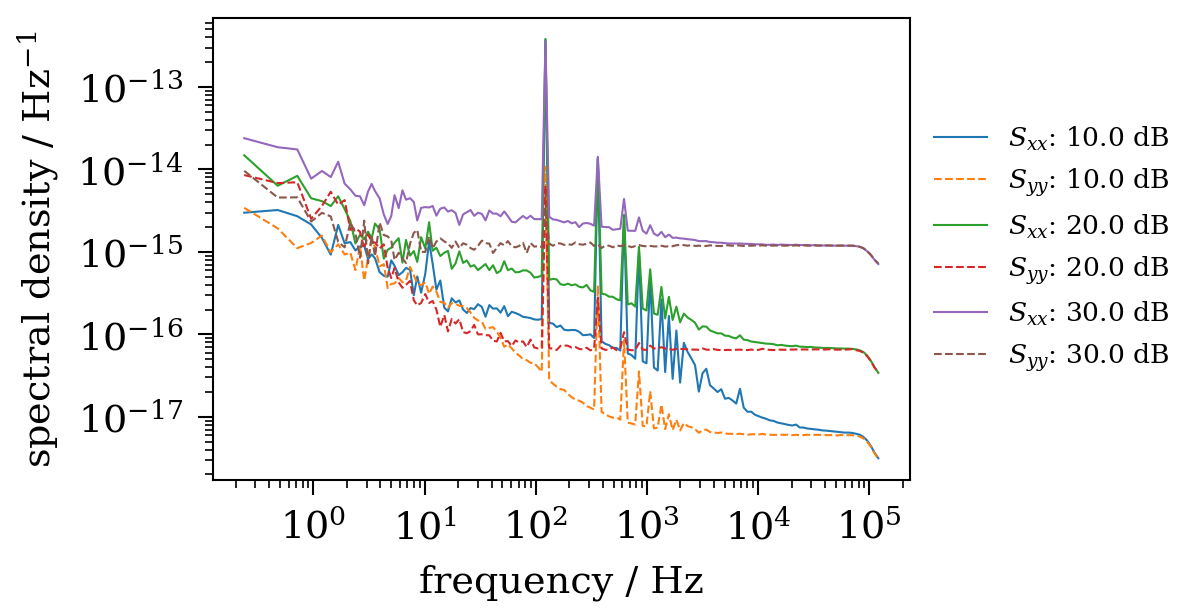

In [27]:
fig, ax = plt.subplots()
plot_Sxx_Syy_attenuation(ax, *sss_mod)

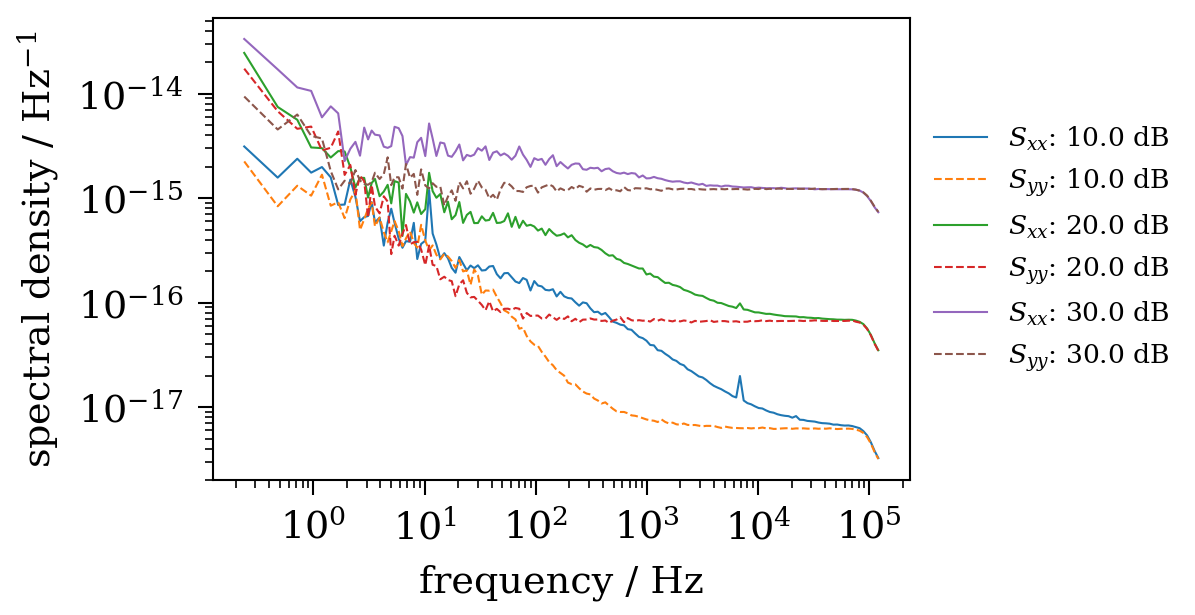

In [28]:
fig, ax = plt.subplots()
plot_Sxx_Syy_attenuation(ax, *sss_on)

if save_Sxx_Syy_vs_frequency_all_attenuations_3410_MHz:
    fig.savefig(save_directory + 'save_Sxx_Syy_vs_frequency_all_attenuations_3410_MHz.pdf')

# Cross-spectrum

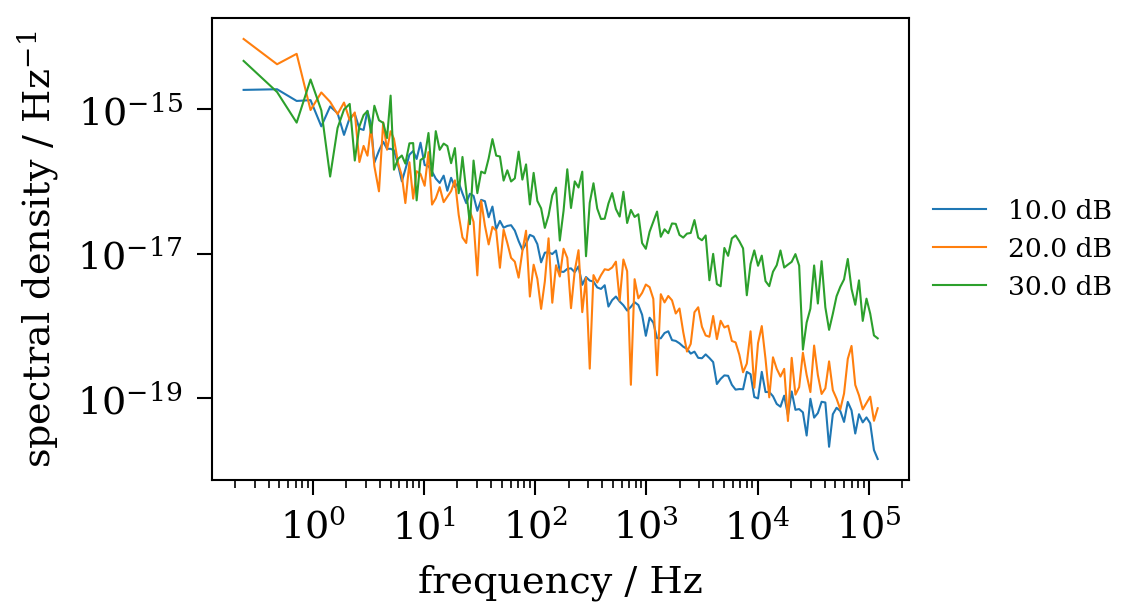

In [29]:
fig, ax = plt.subplots()
plot_Sxy_attenuation(ax, *sss_off)

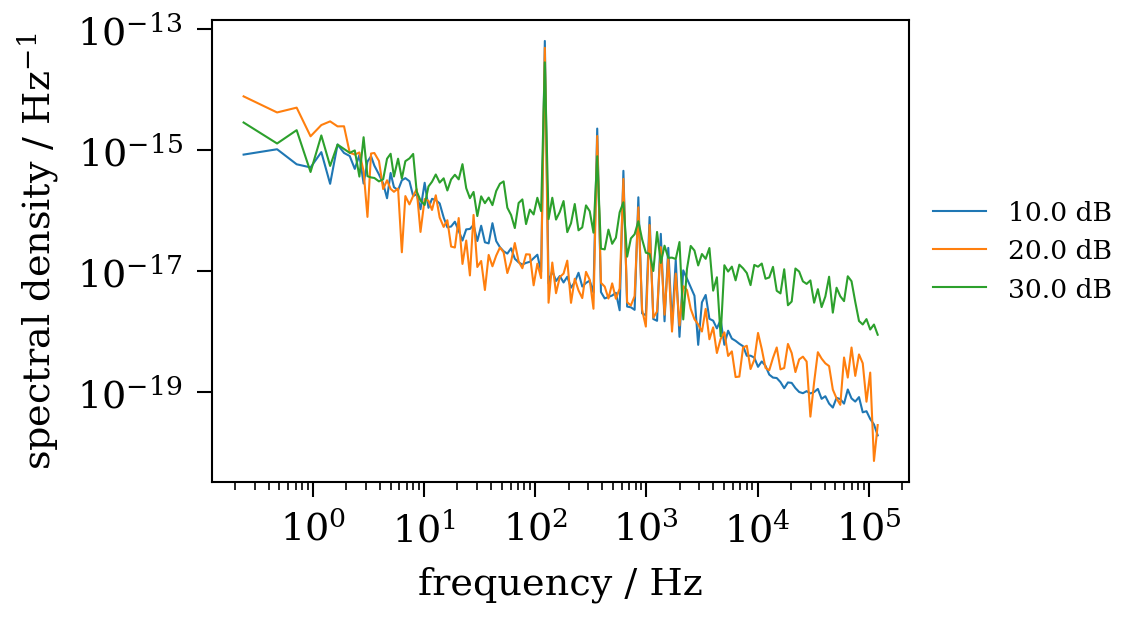

In [30]:
fig, ax = plt.subplots()
plot_Sxy_attenuation(ax, *sss_mod)

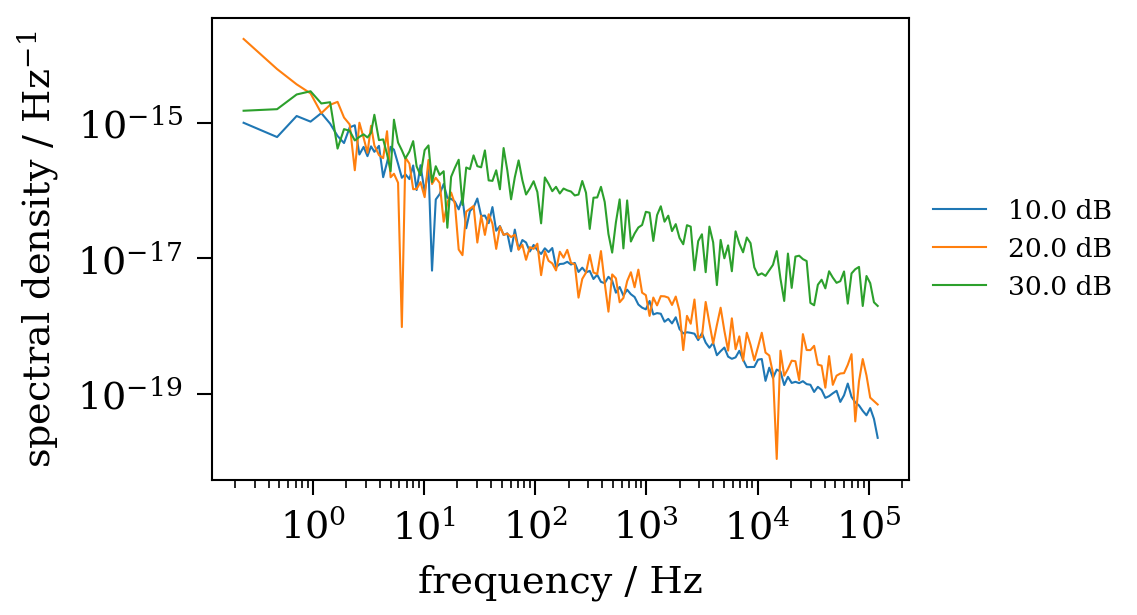

In [31]:
fig, ax = plt.subplots()
plot_Sxy_attenuation(ax, *sss_on)

# Chosen one

In [32]:
def decimate(sss, num_taps=256, downsample=8):
    f_nyquist = sss.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]

In [33]:
chosen_off, chosen_mod, chosen_on = all_sss[0]

In [34]:
print(chosen_mod.stream.roach_state)

StateDict({u'boffile': u'r2iq2xpfb11mcr19gb_2017_Jan_13_1357.bof', u'modulation_output': 2, u'modulation_rate': 7, u'fft_shift_register': 1048448, u'num_tone_samples': 16384, u'bank': 0, u'num_filterbank_channels': 2048, u'loopback': False, u'lo_frequency': 3306727500.0, u'adc_sample_rate': 512000000.0, u'waveform_normalization': 6.103515625e-05, u'hardware_delay_samples': -7987.2, u'num_tones': 1, u'debug_register': 0, u'reference_sequence_number': 2191034829, u'dac_attenuation': 10.0, u'heterodyne': True})


In [35]:
print("resonance frequency is {:.1f} MHz".format(1e-6 * chosen_off.resonator.f_0))
print("internal loss is {:.3g} = 1 / {:.3g}".format(chosen_off.resonator.loss_i, 1 / chosen_off.resonator.loss_i))
print("coupling loss is {:.3g} = 1 / {:.3g}".format(chosen_off.resonator.loss_c, 1 / chosen_off.resonator.loss_c))

resonance frequency is 3409.7 MHz
internal loss is 8.14e-05 = 1 / 1.23e+04
coupling loss is 1.92e-05 = 1 / 5.22e+04


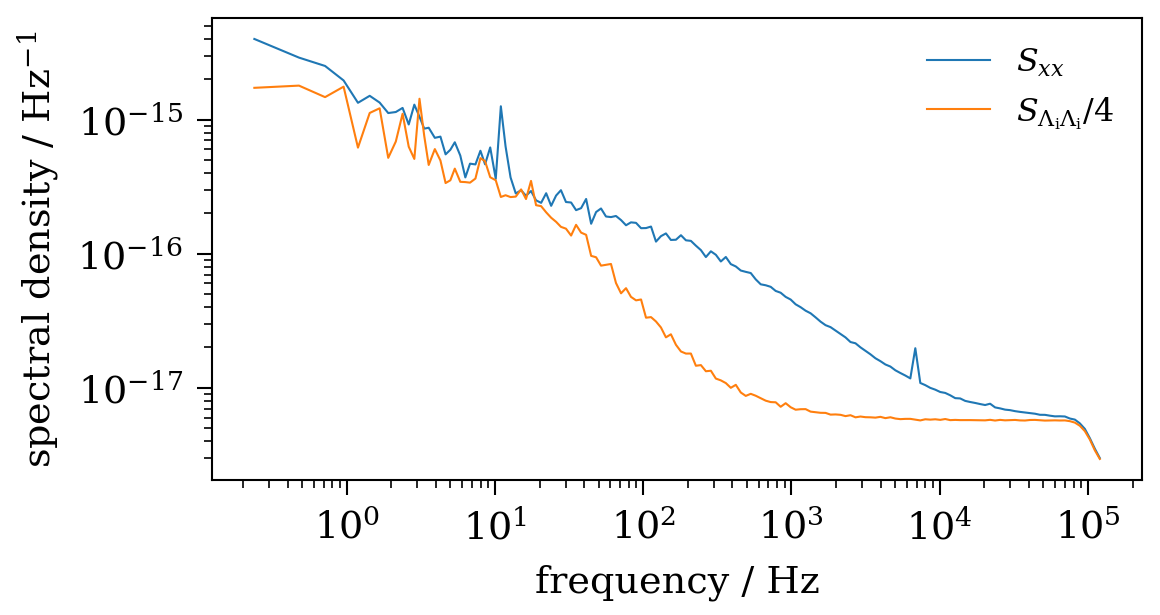

In [36]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('spectral density / Hz$^{-1}$')    
ax.plot(chosen_off.S_frequency, chosen_off.S_xx,
        linestyle='-', label='$S_{xx}$')
ax.plot(chosen_off.S_frequency, chosen_off.S_yy,
        linestyle='-', label='$S_{\Lambda_\mathrm{i} \Lambda_\mathrm{i}} / 4$'),
ax.legend(fontsize='x-small')

if save_mkidarray02_chosen_one_noise_spectra:
    fig.savefig(thesis_directory + 'mkidarray02_chosen_one_noise_spectra.pdf')

In [37]:
def decay(t, t0, xbar, dx0, R_tau_dN0, tau):
    x = np.zeros(t.size)
    x[t < t0] = xbar + dx0
    dx = dx0 / (1 + (1 + R_tau_dN0) * (np.exp((t - t0) / tau) - 1))
    x[t >= t0] = xbar + dx[t >= t0]
    return x
model = lmfit.Model(decay)
model.independent_vars

['t']

In [38]:
# The automatic folding doesn't calculate the period samples correctly for this build
chosen_mod.stream.stream_sample_rate / 2**11

122.0703125

In [39]:
x_fold = chosen_mod.fold(chosen_mod.x, period_samples=2**11)
size = x_fold.size
x_fold = np.roll(x_fold, size // 2)
time_fold = chosen_mod.stream.sample_time[:size]
time_scale = 1e3
x_scale = 1e6
n = time_fold.size

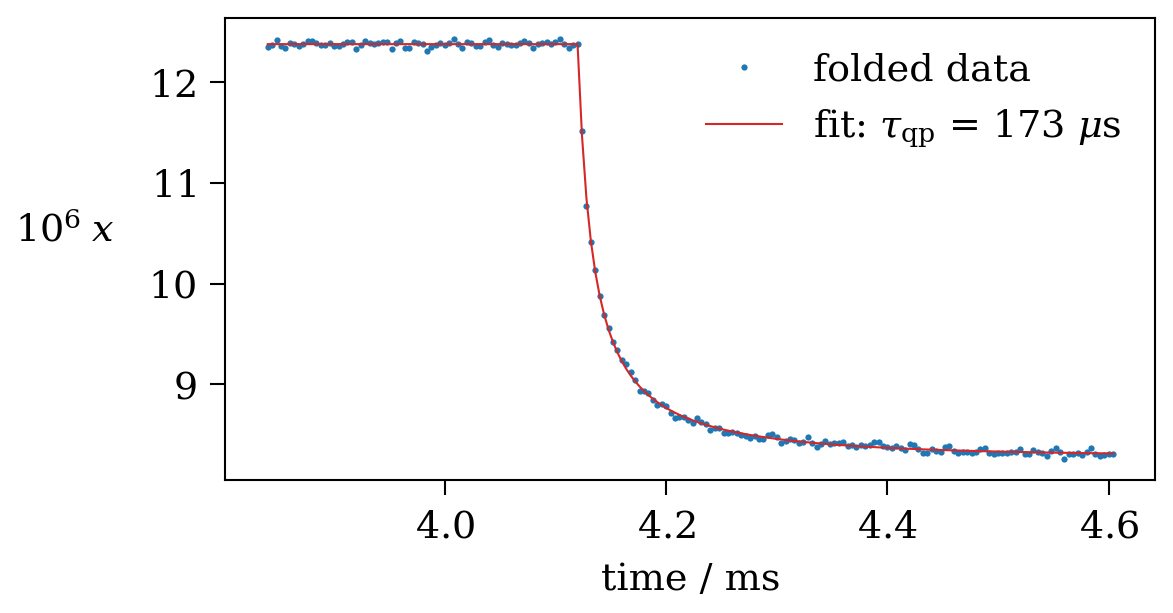

In [41]:
t_decay = time_fold[15 * n // 32:9 * n // 16]
x_decay = x_fold[15 * n // 32:9 * n // 16]

fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('time / ms')
ax.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=20)

ax.plot(time_scale * t_decay,
        x_scale * x_decay,
        '.', color='C0', label='folded data')
result = model.fit(x_decay, t=t_decay, t0=t_decay.min(), xbar=x_decay[-1], dx0=x_decay.ptp(), R_tau_dN0=1, tau=0.0001)
#ax.plot(time_scale * t_decay,
#        x_scale * result.init_fit,
#        ':', color='C1')
ax.plot(time_scale * t_decay,
        x_scale * result.best_fit,
        '-', color='C3', label=r'fit: $\tau_\mathrm{qp}$ = ' + '{:.0f} $\mu$s'.format(1e6 * result.values['tau']))
ax.legend()

if save_mkidarray02_chosen_one_x_fold_fit:
    fig.savefig(thesis_directory + 'mkidarray02_chosen_one_x_fold_fit.pdf')

In [42]:
print(result.fit_report())

[[Model]]
    Model(decay)
[[Fit Statistics]]
    # function evals   = 103
    # data points      = 192
    # variables        = 5
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -6714.191
    Bayesian info crit = -6697.903
[[Variables]]
    t0:          0.00412024 +/- 1.57e-07 (0.00%) (init= 0.00384)
    xbar:        8.2914e-06 +/- 9.35e-09 (0.11%) (init= 8.302563e-06)
    dx0:         4.0888e-06 +/- 9.81e-09 (0.24%) (init= 4.174739e-06)
    R_tau_dN0:   12.0041040 +/- 1.842342 (15.35%) (init= 1)
    tau:         0.00017265 +/- 2.25e-05 (13.05%) (init= 0.0001)
[[Correlations]] (unreported correlations are <  0.100)
    C(R_tau_dN0, tau)            =  0.996 
    C(xbar, dx0)                 = -0.953 
    C(xbar, tau)                 = -0.944 
    C(xbar, R_tau_dN0)           = -0.924 
    C(dx0, tau)                  =  0.899 
    C(dx0, R_tau_dN0)            =  0.882 
    C(t0, R_tau_dN0)             =  0.543 
    C(t0, tau)                   =  

In [43]:
(2 * np.pi * result.values['tau'])**-1

921.8471670355292

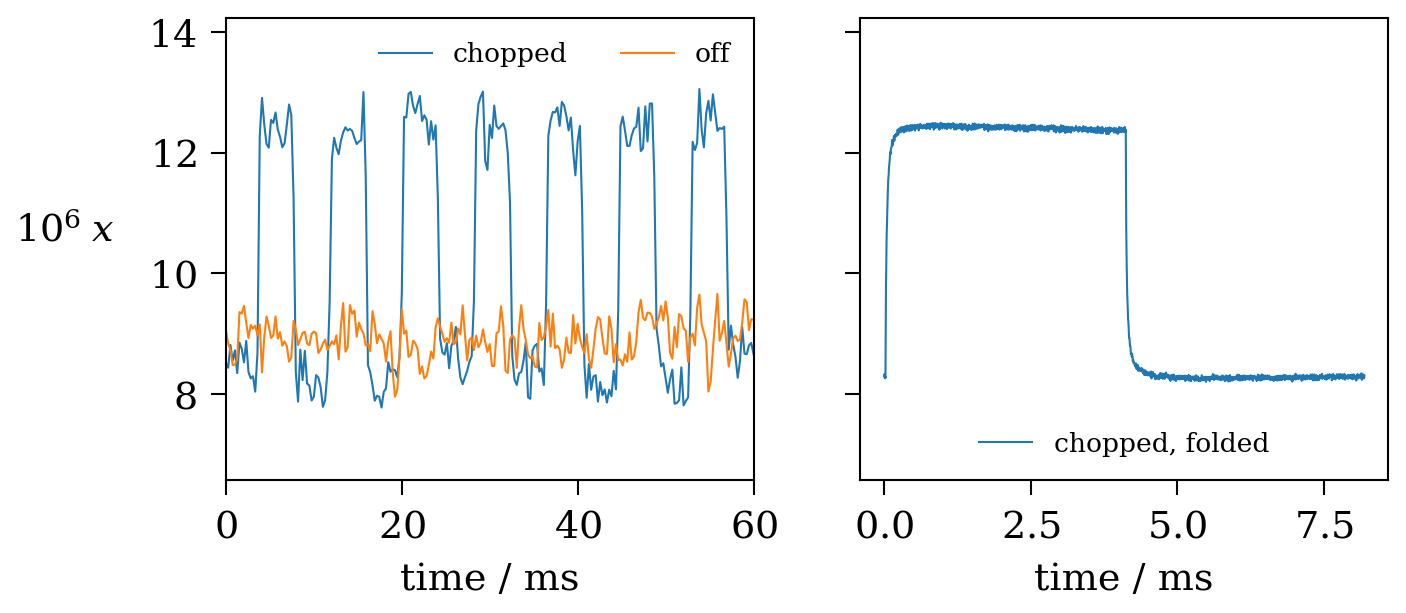

In [44]:
downsample = 2**6
t_off, x_off, q_off = decimate(chosen_off, downsample=downsample)
t_mod, x_mod, q_mod = decimate(chosen_mod, downsample=downsample)

fig, (full_ax, fold_ax) = plt.subplots(1, 2, sharey=True, figsize=(5, 2))
full_ax.set_xlabel('time / ms')
full_ax.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=20)
fold_ax.set_xlabel('time / ms')

full_ax.plot(time_scale * t_mod, x_scale * x_mod, '-', label='chopped')
full_ax.plot(time_scale * t_off, x_scale * x_off, '-', label='off')
full_ax.legend(fontsize='xx-small', ncol=2)
fold_ax.plot(time_scale * time_fold, x_scale * x_fold, '-', label='chopped, folded')
fold_ax.legend(fontsize='xx-small', loc='lower center')
#full_ax.set_ylim(0, 5e-6)
full_ax.set_xlim(0, 60)

if save_mkidarray02_chosen_one_mmw_decimated_and_folded:
    fig.savefig(thesis_directory + 'mkidarray02_chosen_one_mmw_decimated_and_folded.pdf')

In [ ]:
if save_chosen_one_data:
    np.save(data_directory + 'x_fold.npy', x_fold)
    np.save(data_directory + 'time_fold.npy', time_fold)
    chosen_npd = npy.NumpyDirectory(data_directory + 'chosen_one.npd')
    chosen_npd.write(chosen_mod)